# Data Loading and Initial Inspection

In [1]:
from google.colab import files
import pandas as pd
import io

# Upload your CSV file
uploaded = files.upload()

# Read the uploaded CSV with error handling
for filename in uploaded.keys():
    print(f'📁 Uploaded file: {filename}')
    try:
        # Try semicolon delimiter first (as per your data format)
        df = pd.read_csv(io.BytesIO(uploaded[filename]), delimiter=';', encoding='utf-8')
        print(f"Successfully loaded with semicolon delimiter")
        break
    except Exception as e:
        print(f"Error with semicolon delimiter: {e}")
        try:
            # Try comma delimiter as backup
            df = pd.read_csv(io.BytesIO(uploaded[filename]), delimiter=',', encoding='utf-8')
            print(f"Successfully loaded with comma delimiter")
            break
        except Exception as e2:
            print(f"Error with comma delimiter: {e2}")
            # Try with different encoding
            df = pd.read_csv(io.BytesIO(uploaded[filename]), delimiter=';', encoding='latin-1')
            print(f"Successfully loaded with latin-1 encoding")
            break

ModuleNotFoundError: No module named 'google'

# Install Packages and Setup Environment

In [ ]:
# Install required packages
!pip install seaborn plotly kaleido

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Data Preprocessing and Alignment

In [ ]:
# ===========================
# DATA PREPROCESSING
# ===========================

#```python
# ===========================
# FIXED DATA PREPROCESSING FOR MISALIGNED CSV
# ===========================

def fix_csv_alignment(df):
    """
    Fix column misalignment in the CSV where values are shifted left
    """
    print("🔧 Fixing CSV column alignment...")

    # The actual column mapping based on your data inspection:
    # Current 'type' → should be 'gateway_eui'
    # Current 'gateway_eui' → should be 'node_eui'
    # Current 'node_eui' → should be 'snr'
    # Current 'snr' → should be 'rssi'
    # Current 'rssi' → should be 'len'
    # Current 'len' → should be 'cr'
    # Current 'cr' → should be 'datarate'
    # Current 'datarate' → should be 'time'
    # Current 'time' → should be 'data'
    # Current 'data' → should be dropped (NaN values)

    # Create a new DataFrame with correctly aligned columns
    df_fixed = pd.DataFrame()

    # Map the misaligned columns to correct ones
    df_fixed['type'] = 16  # Assuming this is always 16 for your data type
    df_fixed['gateway_eui'] = df['type']  # gateway_eui was in 'type' column
    df_fixed['node_eui'] = df['gateway_eui']  # node_eui was in 'gateway_eui' column
    df_fixed['snr'] = df['node_eui']  # snr was in 'node_eui' column
    df_fixed['rssi'] = df['snr']  # rssi was in 'snr' column
    df_fixed['len'] = df['rssi']  # len was in 'rssi' column
    df_fixed['cr'] = df['len']  # cr was in 'len' column
    df_fixed['datarate'] = df['cr']  # datarate was in 'cr' column
    df_fixed['time'] = df['datarate']  # time was in 'datarate' column
    df_fixed['data'] = df['time']  # data was in 'time' column

    print("✅ Column alignment fixed!")
    print("📊 Corrected data sample:")
    print(f"  gateway_eui: {df_fixed['gateway_eui'].iloc[0]}")
    print(f"  node_eui: {df_fixed['node_eui'].iloc[0]}")
    print(f"  snr: {df_fixed['snr'].iloc[0]}")
    print(f"  rssi: {df_fixed['rssi'].iloc[0]}")
    print(f"  len: {df_fixed['len'].iloc[0]}")
    print(f"  datarate: {df_fixed['datarate'].iloc[0]}")
    print(f"  time: {df_fixed['time'].iloc[0]}")

    return df_fixed

def preprocess_lora_data(df):
    """
    Preprocess LoRa characterization data with fixed alignment
    """
    # First fix the column alignment
    df = fix_csv_alignment(df)

    print("\n🔄 Processing corrected data...")

    # Convert timestamp - now 'time' has the correct datetime values
    try:
        df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
        valid_timestamps = df['timestamp'].notna().sum()
        print(f"✅ Successfully parsed {valid_timestamps} timestamps")
        if valid_timestamps > 0:
            print(f"📅 Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    except Exception as e:
        print(f"❌ Timestamp parsing error: {e}")
        df['timestamp'] = pd.NaT

    # Extract SF and BW from datarate - now 'datarate' has correct values like 'SF7BW125'
    if 'datarate' in df.columns:
        df['sf'] = df['datarate'].str.extract(r'SF(\d+)', expand=False).astype(float)
        df['bw'] = df['datarate'].str.extract(r'BW(\d+)', expand=False).astype(float)

        # Handle missing BW values (some might just be SF7BW125 without explicit BW)
        df['bw'] = df['bw'].fillna(125)  # Default to 125 if not specified

        print(f"✅ Extracted SF values: {sorted(df['sf'].dropna().unique())}")
        print(f"✅ Extracted BW values: {sorted(df['bw'].dropna().unique())}")
    else:
        print("❌ 'datarate' column not found")
        return df

    # Convert numeric columns - now they should have correct numeric values
    numeric_cols = ['rssi', 'snr', 'len', 'node_eui']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            valid_count = df[col].notna().sum()
            print(f"✅ Converted {col}: {valid_count} valid values")
            if valid_count > 0:
                print(f"   Range: {df[col].min()} to {df[col].max()}")
        else:
            print(f"❌ Column '{col}' not found")

    # Create configuration identifier
    if all(col in df.columns for col in ['sf', 'bw', 'len']):
        df['config'] = (df['sf'].astype(str) + '_BW' +
                       df['bw'].astype(str) + '_' +
                       df['len'].astype(str) + 'B')

        # Create SF category
        df['sf_category'] = df['sf'].map({7: 'MIN-SF7', 9: 'MEAN-SF9', 12: 'MAX-SF12'})

        unique_configs = df['config'].nunique()
        print(f"✅ Created {unique_configs} unique configurations")
        print(f"📋 Configurations: {sorted(df['config'].unique())}")

    # Add time-based features
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60
        duration = df['time_minutes'].max()
        print(f"✅ Total experiment duration: {duration:.1f} minutes")

    # Remove rows with missing critical data
    initial_rows = len(df)
    critical_cols = ['sf', 'rssi', 'snr', 'len']
    df = df.dropna(subset=critical_cols)
    final_rows = len(df)

    if initial_rows != final_rows:
        print(f"⚠️ Removed {initial_rows - final_rows} rows with missing critical data")

    print(f"\n📊 Final dataset: {final_rows} rows, {len(df.columns)} columns")

    return df

# Apply the corrected preprocessing
print("🚀 Starting corrected data preprocessing...")
df = preprocess_lora_data(df)

# Display corrected dataset info
if len(df) > 0:
    print("\n" + "="*50)
    print("📊 CORRECTED DATASET OVERVIEW")
    print("="*50)
    print(f"Total packets received: {len(df)}")
    if 'timestamp' in df.columns and df['timestamp'].notna().any():
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"Configurations tested: {df['config'].nunique()}")
    print(f"SF values: {sorted(df['sf'].unique())}")
    print(f"BW values: {sorted(df['bw'].unique())}")
    print(f"Payload sizes: {sorted(df['len'].unique())} bytes")
    print(f"RSSI range: {df['rssi'].min()} to {df['rssi'].max()} dBm")
    print(f"SNR range: {df['snr'].min()} to {df['snr'].max()} dB")

    # Show sample of corrected data
    print(f"\n📋 Sample of corrected data:")
    display_cols = ['gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'datarate', 'time', 'config']
    available_cols = [col for col in display_cols if col in df.columns]
    print(df[available_cols].head(3))
else:
    print("❌ No valid data after preprocessing!")

🚀 Starting corrected data preprocessing...
🔧 Fixing CSV column alignment...
✅ Column alignment fixed!
📊 Corrected data sample:
  gateway_eui: 0000B827EB24A52C
  node_eui: 8
  snr: 6
  rssi: -37
  len: 20
  datarate: SF7BW125
  time: 2025-06-27 17:55:41

🔄 Processing corrected data...
✅ Successfully parsed 43 timestamps
📅 Time range: 2025-06-27 17:55:41 to 2025-06-27 18:08:42
✅ Extracted SF values: [np.float64(7.0), np.float64(9.0), np.float64(12.0)]
✅ Extracted BW values: [np.float64(125.0), np.float64(500.0)]
✅ Converted rssi: 43 valid values
   Range: -37 to -21
✅ Converted snr: 43 valid values
   Range: -10 to 8
✅ Converted len: 43 valid values
   Range: 20 to 80
✅ Converted node_eui: 43 valid values
   Range: 8 to 8
✅ Created 12 unique configurations
📋 Configurations: ['12.0_BW125.0_20B', '12.0_BW125.0_50B', '12.0_BW125.0_80B', '12.0_BW500.0_20B', '7.0_BW125.0_20B', '7.0_BW125.0_50B', '7.0_BW125.0_80B', '7.0_BW500.0_20B', '9.0_BW125.0_20B', '9.0_BW125.0_50B', '9.0_BW125.0_80B', '9.

# Inspect Corrected Data Structure

In [ ]:
# Safe data inspection
print("Inspecting your CSV structure...")
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print("\nFirst row sample:")
for col in df.columns:
    print(f"  {col}: {repr(df[col].iloc[0]) if len(df) > 0 else 'Empty'}")

# Check if 'time' column has valid datetime strings
if 'time' in df.columns:
    print(f"\nTime column samples:")
    print(df['time'].head(3).tolist())

Inspecting your CSV structure...
Columns: ['type', 'gateway_eui', 'node_eui', 'snr', 'rssi', 'len', 'cr', 'datarate', 'time', 'data', 'timestamp', 'sf', 'bw', 'config', 'sf_category', 'time_minutes']
Shape: (43, 16)

First row sample:
  type: np.float64(nan)
  gateway_eui: '0000B827EB24A52C'
  node_eui: np.int64(8)
  snr: np.int64(6)
  rssi: np.int64(-37)
  len: np.int64(20)
  cr: np.int64(5)
  datarate: 'SF7BW125'
  time: '2025-06-27 17:55:41'
  data: '{"RSSI": -37, "SNR": 6, "TC": 26.87}'
  timestamp: Timestamp('2025-06-27 17:55:41')
  sf: np.float64(7.0)
  bw: np.float64(125.0)
  config: '7.0_BW125.0_20B'
  sf_category: 'MIN-SF7'
  time_minutes: np.float64(0.0)

Time column samples:
['2025-06-27 17:55:41', '2025-06-27 17:55:57', '2025-06-27 17:56:28']


# Packet Delivery Rate (PDR) Analysis

In [ ]:
# ===========================
# PACKET DELIVERY RATE ANALYSIS
# ===========================

def calculate_pdr_statistics(df):
    """
    Calculate PDR and related statistics for each configuration
    """
    expected_packets = 4  # As specified in your experiment setup

    stats = df.groupby(['sf', 'bw', 'len']).agg({
        'rssi': ['mean', 'std', 'min', 'max'],
        'snr': ['mean', 'std', 'min', 'max'],
        'timestamp': ['count', 'min', 'max']
    }).round(2)

    # Flatten column names
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]

    # Calculate PDR
    stats['packets_received'] = stats['timestamp_count']
    stats['expected_packets'] = expected_packets
    stats['pdr_percent'] = (stats['packets_received'] / expected_packets * 100).round(1)
    stats['packet_loss_percent'] = (100 - stats['pdr_percent']).round(1)

    # Calculate duration
    stats['duration_minutes'] = ((stats['timestamp_max'] - stats['timestamp_min']).dt.total_seconds() / 60).round(1)

    # Reset index for easier plotting
    stats = stats.reset_index()
    stats['config_name'] = (stats['sf'].astype(str) + '_BW' +
                           stats['bw'].astype(str) + '_' +
                           stats['len'].astype(str) + 'B')

    return stats

# Calculate statistics
pdr_stats = calculate_pdr_statistics(df)
print("PDR Statistics Summary")
print(pdr_stats[['sf', 'bw', 'len', 'packets_received', 'pdr_percent', 'rssi_mean', 'snr_mean']].to_string(index=False))

PDR Statistics Summary
  sf    bw  len  packets_received  pdr_percent  rssi_mean  snr_mean
 7.0 125.0   20                 3         75.0     -36.33      4.67
 7.0 125.0   50                 3         75.0     -35.33      5.33
 7.0 125.0   80                 4        100.0     -35.00      6.00
 7.0 500.0   20                 4        100.0     -32.75      4.75
 9.0 125.0   20                 4        100.0     -35.50      7.00
 9.0 125.0   50                 3         75.0     -30.67      6.67
 9.0 125.0   80                 4        100.0     -30.00      6.75
 9.0 500.0   20                 4        100.0     -35.25      6.25
12.0 125.0   20                 4        100.0     -33.25     -2.75
12.0 125.0   50                 3         75.0     -35.00      0.67
12.0 125.0   80                 3         75.0     -36.33      6.67
12.0 500.0   20                 4        100.0     -30.50      3.75


# Plot 1: Packet Delivery Rate by Configuration

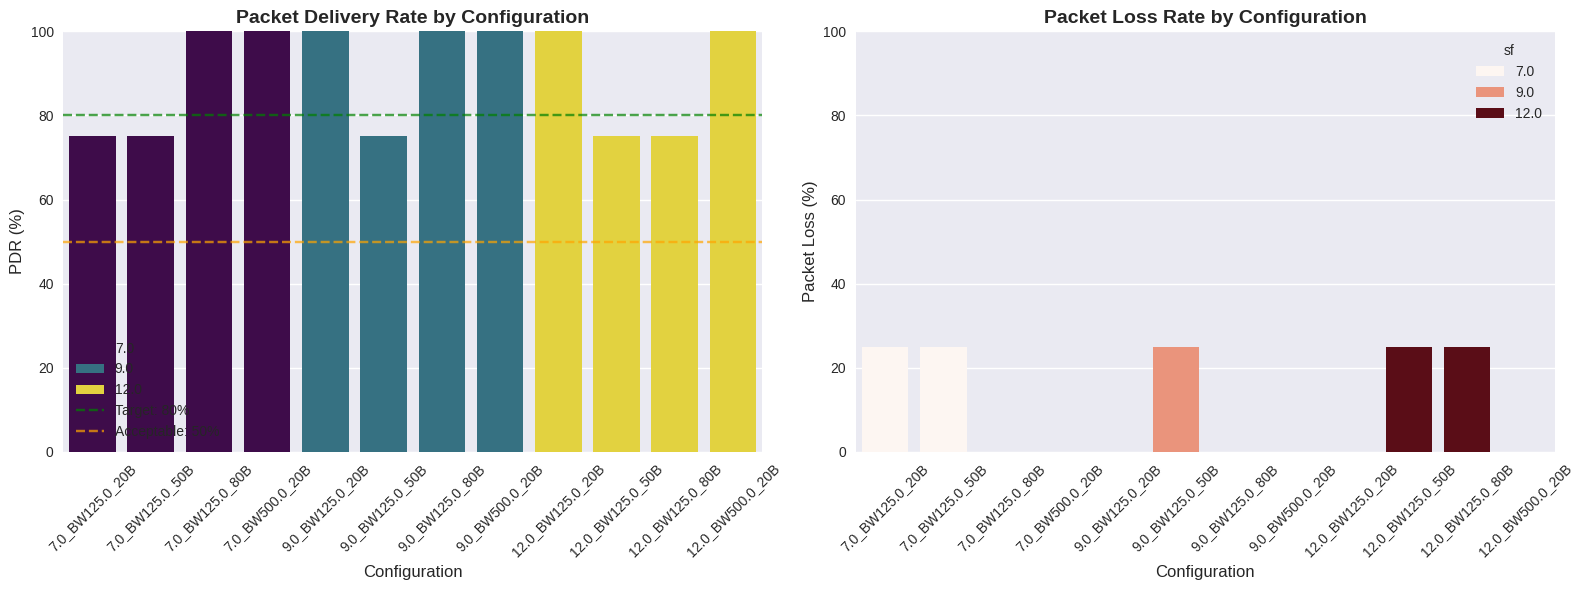


PDR Analysis Summary:
Best performing config: 7.0_BW125.0_80B (100.0%)
Worst performing config: 7.0_BW125.0_20B (75.0%)
Average PDR: 89.6%


In [ ]:
# ===========================
# PLOT 1: PACKET DELIVERY RATE BY CONFIGURATION
# ===========================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of PDR
sns.barplot(data=pdr_stats, x='config_name', y='pdr_percent',
           hue='sf', palette='viridis', ax=ax1)
ax1.set_title('Packet Delivery Rate by Configuration', fontsize=14, fontweight='bold')
ax1.set_xlabel('Configuration', fontsize=12)
ax1.set_ylabel('PDR (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target: 80%')
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='Acceptable: 50%')
ax1.legend()
ax1.set_ylim(0, 100) # Set y-axis limit for PDR plot

# Packet loss visualization
sns.barplot(data=pdr_stats, x='config_name', y='packet_loss_percent',
           hue='sf', palette='Reds', ax=ax2)
ax2.set_title('Packet Loss Rate by Configuration', fontsize=14, fontweight='bold')
ax2.set_xlabel('Configuration', fontsize=12)
ax2.set_ylabel('Packet Loss (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100) # Set y-axis limit for packet loss plot

plt.tight_layout()
plt.show()

# Summary table
print("\nPDR Analysis Summary:")
print(f"Best performing config: {pdr_stats.loc[pdr_stats['pdr_percent'].idxmax(), 'config_name']} ({pdr_stats['pdr_percent'].max()}%)")
print(f"Worst performing config: {pdr_stats.loc[pdr_stats['pdr_percent'].idxmin(), 'config_name']} ({pdr_stats['pdr_percent'].min()}%)")
print(f"Average PDR: {pdr_stats['pdr_percent'].mean():.1f}%")

# Plot 2: Signal Quality Analysis (RSSI vs SNR)

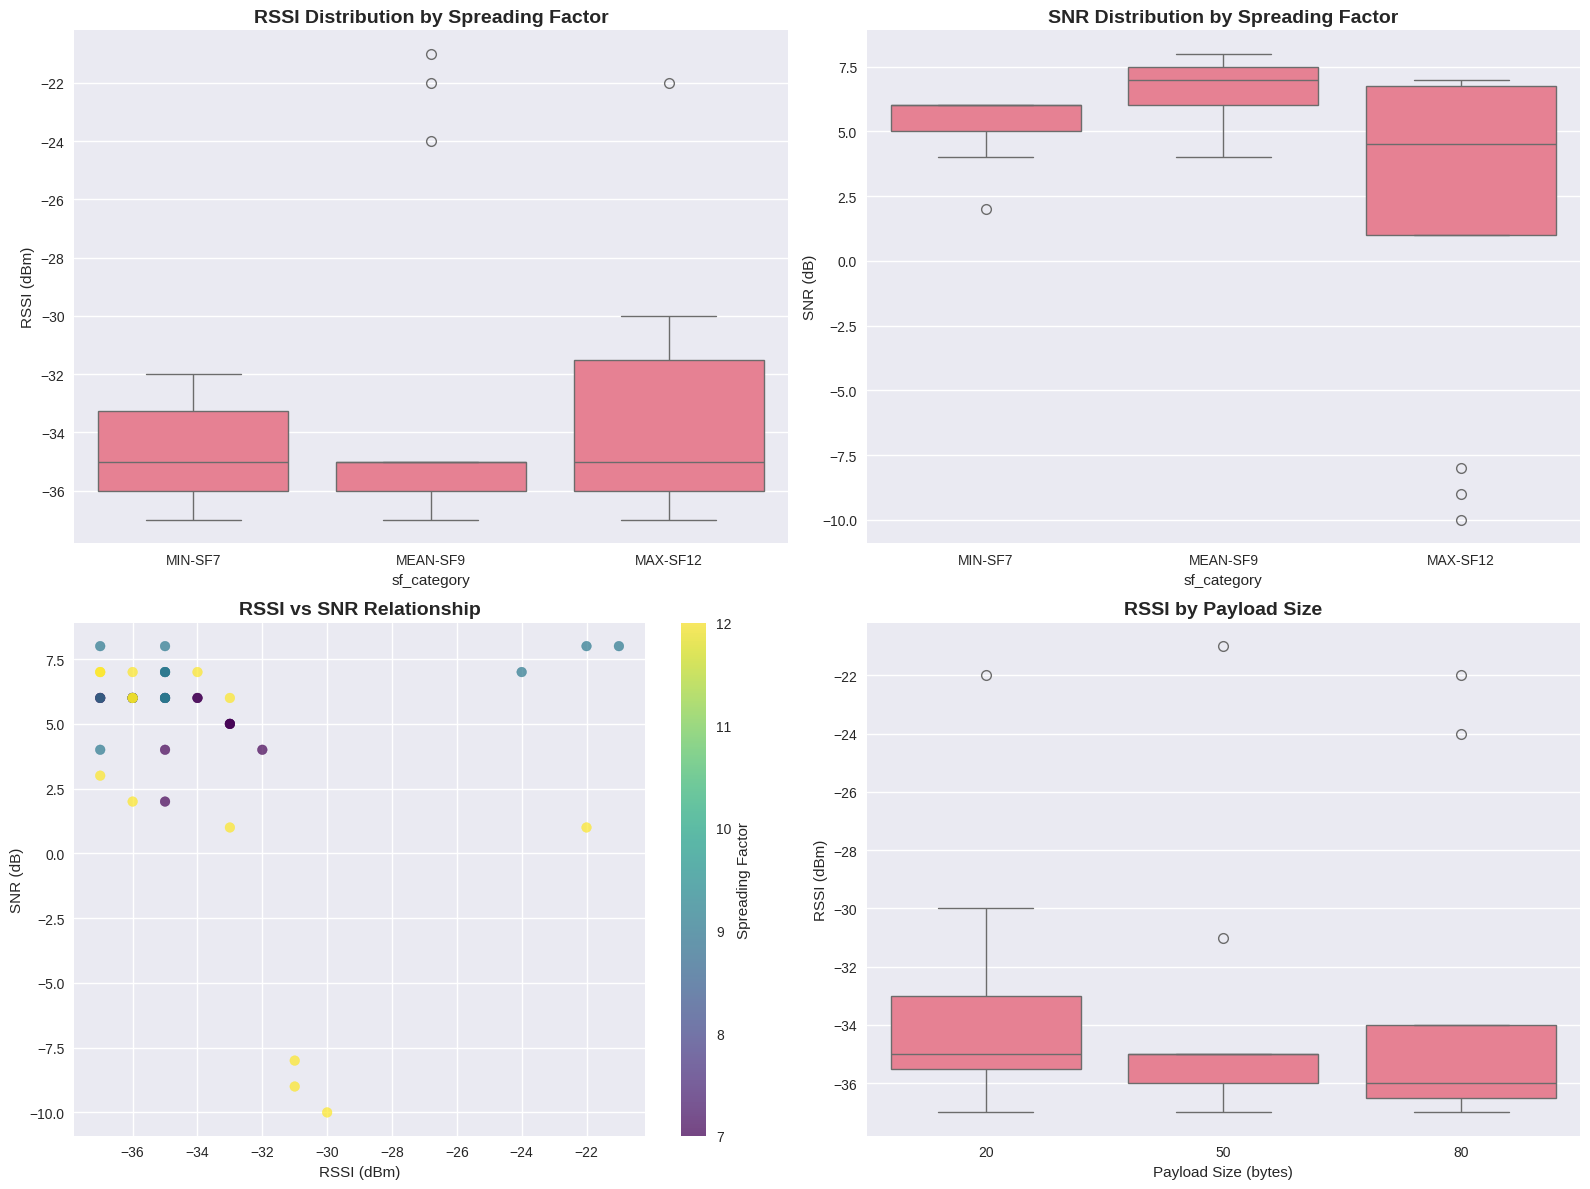

In [ ]:
# ===========================
# PLOT 2: SIGNAL QUALITY ANALYSIS (RSSI vs SNR)
# ===========================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# RSSI distribution by SF
sns.boxplot(data=df, x='sf_category', y='rssi', ax=ax1)
ax1.set_title('RSSI Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax1.set_ylabel('RSSI (dBm)')

# SNR distribution by SF
sns.boxplot(data=df, x='sf_category', y='snr', ax=ax2)
ax2.set_title('SNR Distribution by Spreading Factor', fontsize=14, fontweight='bold')
ax2.set_ylabel('SNR (dB)')

# RSSI vs SNR scatter plot
scatter = ax3.scatter(df['rssi'], df['snr'], c=df['sf'], cmap='viridis', alpha=0.7)
ax3.set_xlabel('RSSI (dBm)')
ax3.set_ylabel('SNR (dB)')
ax3.set_title('RSSI vs SNR Relationship', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='Spreading Factor')

# Signal quality by payload size
sns.boxplot(data=df, x='len', y='rssi', ax=ax4)
ax4.set_title('RSSI by Payload Size', fontsize=14, fontweight='bold')
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('RSSI (dBm)')

plt.tight_layout()
plt.show()

# Box Plot: PDR vs Configuration

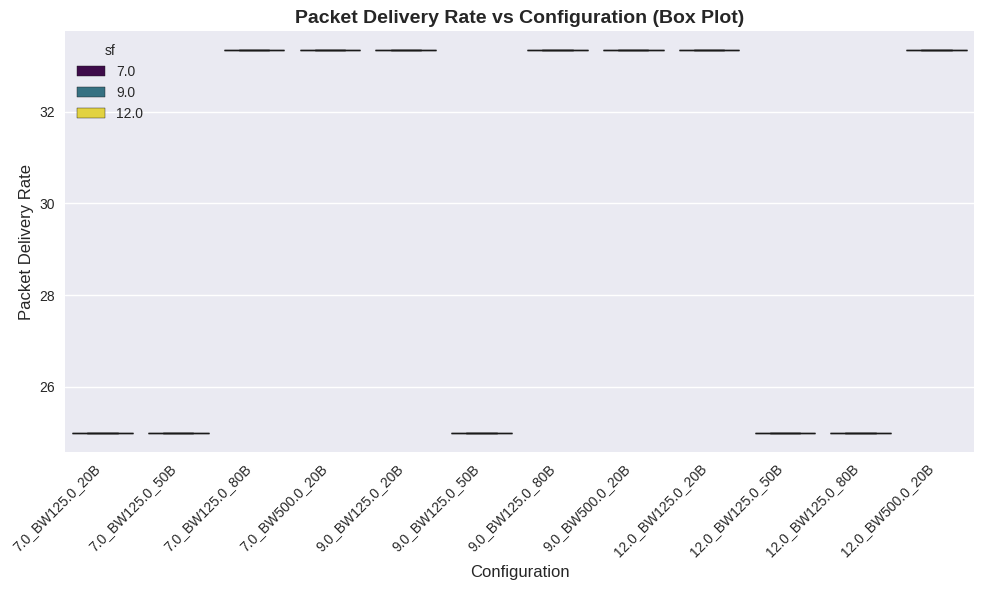

In [ ]:
# prompt: A box plot that plots packet delivery rate (divide packet received by 12) against configuration. Leverage the code from the cells above

# Ensure the 'pdr' column exists, calculated as packets_received / 12
# You should already have 'packets_received' column from the calculate_pdr_statistics function
df_plot = pdr_stats.copy()
df_plot['pdr'] = df_plot['packets_received'] * 100 / 12

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='config_name', y='pdr', hue='sf', palette='viridis')
plt.title('Packet Delivery Rate vs Configuration (Box Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Configuration', fontsize=12)
plt.ylabel('Packet Delivery Rate', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()

# Box Plot: PDR vs SF

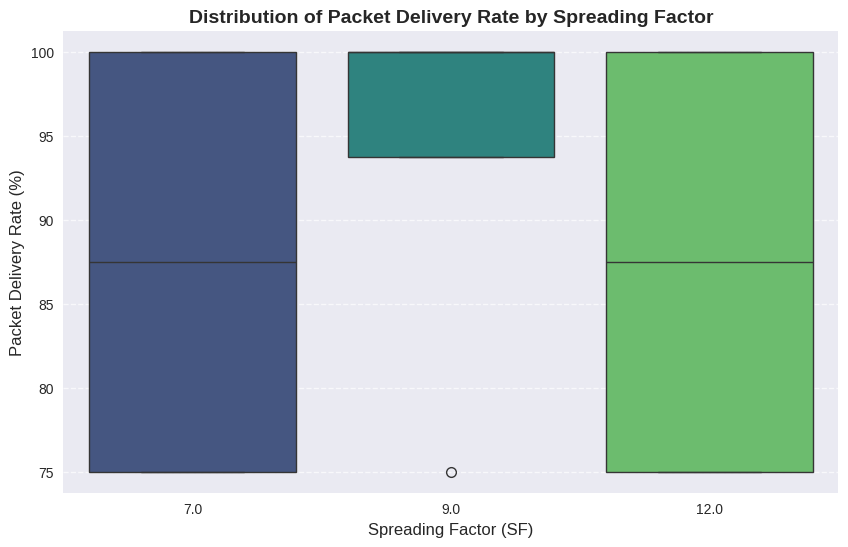

In [ ]:
# prompt: A box plot that plots packet delivery rate in % (divide packet received by 12) against each SF. Leverage the code from the cells above

# Recalculate PDR for each individual packet based on the expectation of 12 packets per config run
# This assumes that each group of 12 packets for a specific config constitutes a single 'test' or trial run.
# However, the current data format has individual packets with a 'config' column.
# A better approach for a box plot by SF might be to calculate PDR per configuration (as already done in pdr_stats),
# but then group these PDR values by SF. This shows the *distribution* of PDR values *across different configurations* within each SF.

# Let's use the pdr_stats DataFrame, which already has PDR calculated for each config (SF, BW, Length combination).
# We will plot the distribution of these PDR values, grouped by SF.

plt.figure(figsize=(10, 6))
sns.boxplot(data=pdr_stats, x='sf', y='pdr_percent', palette='viridis')
plt.title('Distribution of Packet Delivery Rate by Spreading Factor', fontsize=14, fontweight='bold')
plt.xlabel('Spreading Factor (SF)', fontsize=12)
plt.ylabel('Packet Delivery Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 3: Interactive Time Series Analysis

In [ ]:
# ===========================
# PLOT 3: INTERACTIVE TIME SERIES ANALYSIS
# ===========================

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('RSSI over Time', 'SNR over Time', 'Packet Reception Timeline'),
    vertical_spacing=0.1
)

# Color map for different SF values
colors = {7: 'green', 9: 'blue', 12: 'red'}

for sf in sorted(df['sf'].unique()):
    sf_data = df[df['sf'] == sf]

    # RSSI time series
    fig.add_trace(
        go.Scatter(x=sf_data['timestamp'], y=sf_data['rssi'],
                  mode='markers+lines', name=f'SF{sf} RSSI',
                  marker=dict(color=colors[sf], size=4),
                  line=dict(color=colors[sf], width=1)),
        row=1, col=1
    )

    # SNR time series
    fig.add_trace(
        go.Scatter(x=sf_data['timestamp'], y=sf_data['snr'],
                  mode='markers+lines', name=f'SF{sf} SNR',
                  marker=dict(color=colors[sf], size=4),
                  line=dict(color=colors[sf], width=1)),
        row=2, col=1
    )

    # Packet timeline
    fig.add_trace(
        go.Scatter(x=sf_data['timestamp'], y=[sf]*len(sf_data),
                  mode='markers', name=f'SF{sf} Packets',
                  marker=dict(color=colors[sf], size=8, symbol='diamond')),
        row=3, col=1
    )

fig.update_layout(height=800, title_text="📈 Time Series Analysis of LoRa Link Quality")
fig.update_xaxes(title_text="Time", row=3, col=1)
fig.update_yaxes(title_text="RSSI (dBm)", row=1, col=1)
fig.update_yaxes(title_text="SNR (dB)", row=2, col=1)
fig.update_yaxes(title_text="Spreading Factor", row=3, col=1)

fig.show()

# Plot 4: Link Budget Analysis

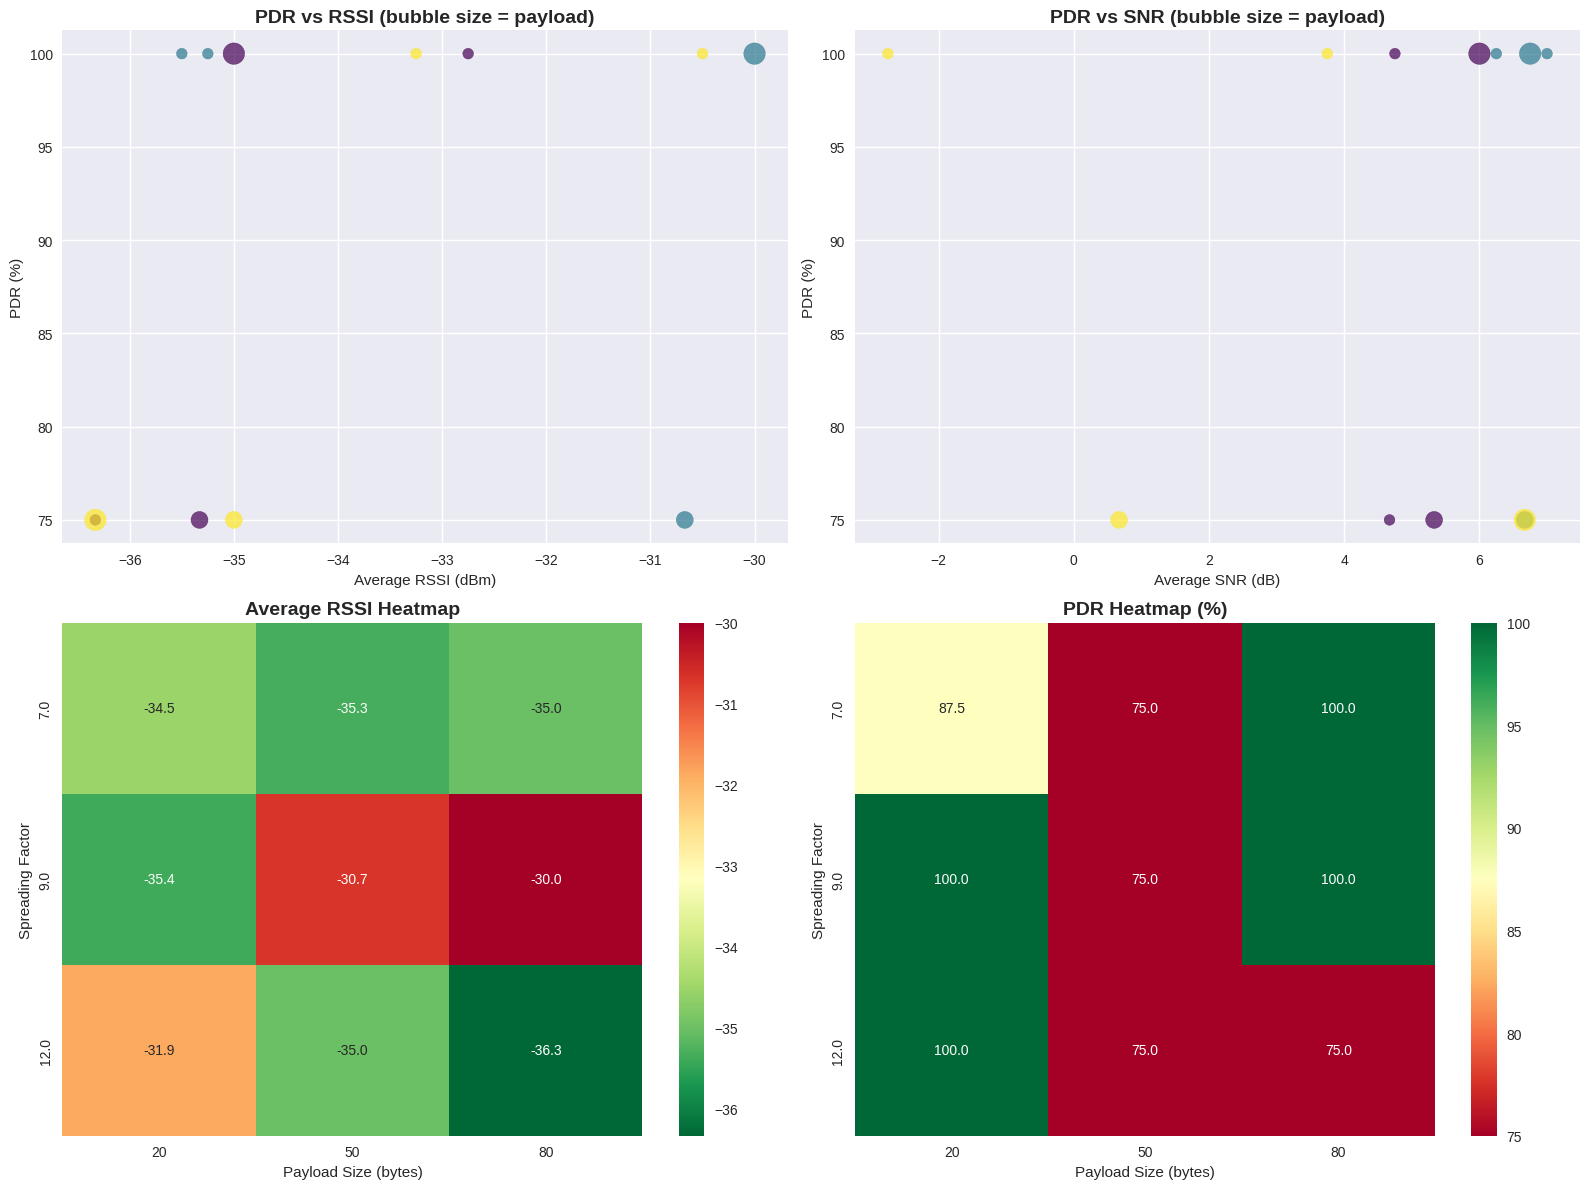

In [ ]:
# ===========================
# PLOT 4: LINK BUDGET ANALYSIS
# ===========================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# PDR vs Average RSSI
ax1.scatter(pdr_stats['rssi_mean'], pdr_stats['pdr_percent'],
           c=pdr_stats['sf'], cmap='viridis', s=pdr_stats['len']*3, alpha=0.7)
ax1.set_xlabel('Average RSSI (dBm)')
ax1.set_ylabel('PDR (%)')
ax1.set_title('PDR vs RSSI (bubble size = payload)', fontsize=14, fontweight='bold')

# PDR vs Average SNR
ax2.scatter(pdr_stats['snr_mean'], pdr_stats['pdr_percent'],
           c=pdr_stats['sf'], cmap='viridis', s=pdr_stats['len']*3, alpha=0.7)
ax2.set_xlabel('Average SNR (dB)')
ax2.set_ylabel('PDR (%)')
ax2.set_title('PDR vs SNR (bubble size = payload)', fontsize=14, fontweight='bold')

# Signal strength heatmap
pivot_rssi = pdr_stats.pivot_table(values='rssi_mean', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_rssi, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3)
ax3.set_title('Average RSSI Heatmap', fontsize=14, fontweight='bold')
ax3.set_xlabel('Payload Size (bytes)')
ax3.set_ylabel('Spreading Factor')

# PDR heatmap
pivot_pdr = pdr_stats.pivot_table(values='pdr_percent', index='sf', columns='len', fill_value=0)
sns.heatmap(pivot_pdr, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax4)
ax4.set_title('PDR Heatmap (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Payload Size (bytes)')
ax4.set_ylabel('Spreading Factor')

plt.tight_layout()
plt.show()

# Plot 5: Payload Size Impact Analysis

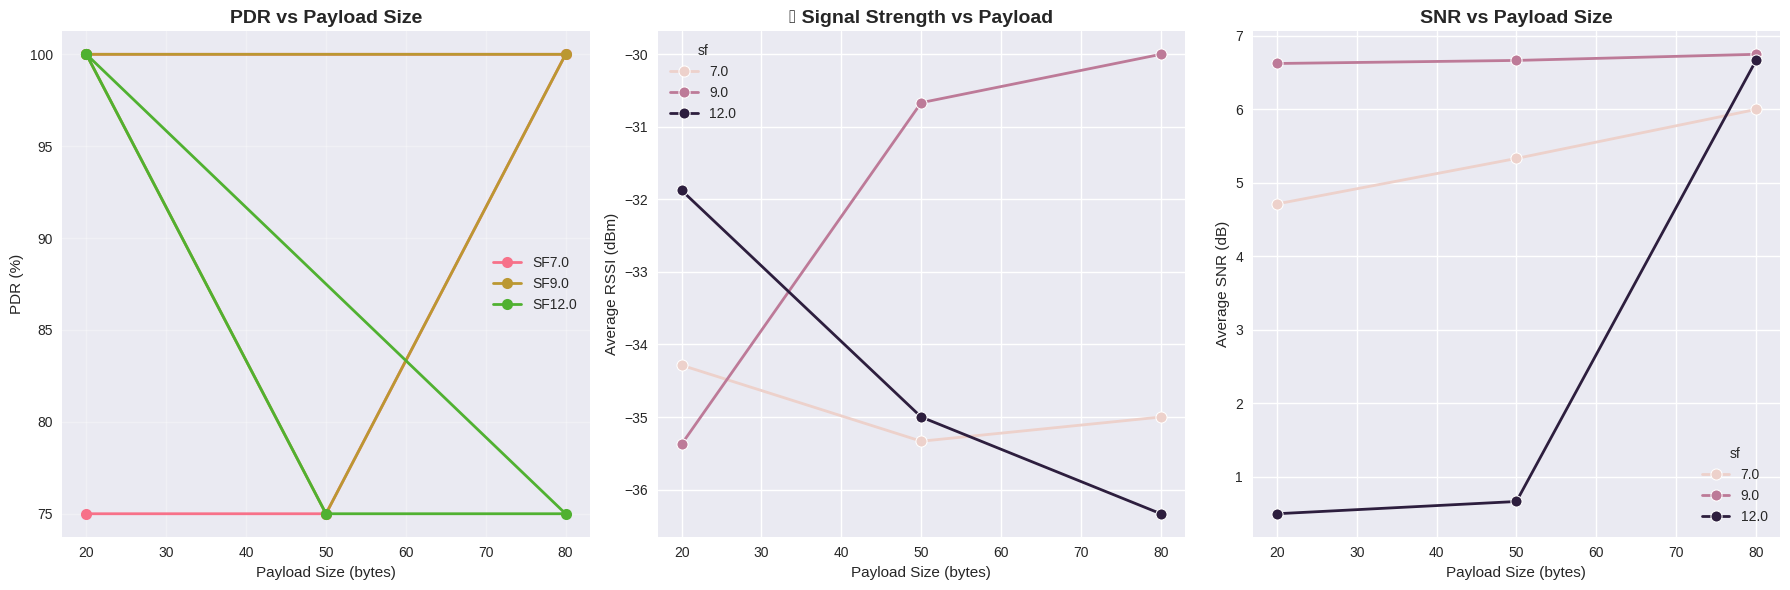

In [ ]:
# ===========================
# PLOT 5: PAYLOAD SIZE IMPACT ANALYSIS
# ===========================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# PDR vs Payload Size by SF
for sf in sorted(df['sf'].unique()):
    sf_stats = pdr_stats[pdr_stats['sf'] == sf]
    ax1.plot(sf_stats['len'], sf_stats['pdr_percent'],
            marker='o', linewidth=2, markersize=8, label=f'SF{sf}')

ax1.set_xlabel('Payload Size (bytes)')
ax1.set_ylabel('PDR (%)')
ax1.set_title('PDR vs Payload Size', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Average signal quality vs payload size
payload_analysis = df.groupby(['len', 'sf']).agg({
    'rssi': 'mean',
    'snr': 'mean'
}).reset_index()

sns.lineplot(data=payload_analysis, x='len', y='rssi', hue='sf',
            marker='o', linewidth=2, markersize=8, ax=ax2)
ax2.set_xlabel('Payload Size (bytes)')
ax2.set_ylabel('Average RSSI (dBm)')
ax2.set_title('📡 Signal Strength vs Payload', fontsize=14, fontweight='bold')

sns.lineplot(data=payload_analysis, x='len', y='snr', hue='sf',
            marker='o', linewidth=2, markersize=8, ax=ax3)
ax3.set_xlabel('Payload Size (bytes)')
ax3.set_ylabel('Average SNR (dB)')
ax3.set_title('SNR vs Payload Size', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 6: Network Performance Radar Chart

In [ ]:
# ===========================
# PLOT 6: NETWORK PERFORMANCE RADAR CHART
# ===========================

# Calculate normalized metrics for radar chart
def create_radar_chart(stats_df):
    # Normalize metrics (0-100 scale)
    metrics = {
        'PDR': 'pdr_percent',
        'Signal Strength': 'rssi_mean',  # Will be inverted (higher RSSI = better)
        'SNR Quality': 'snr_mean',
        'Consistency': 'duration_minutes'  # Proxy for stability
    }

    radar_data = []
    for sf in [7, 9, 12]:
        sf_data = stats_df[stats_df['sf'] == sf]
        if len(sf_data) > 0:
            # Calculate average metrics for this SF
            pdr_avg = sf_data['pdr_percent'].mean()
            rssi_avg = sf_data['rssi_mean'].mean()

            # Normalize RSSI: Map a typical range (e.g., -120 to -30 dBm) to 0-100
            # Higher (less negative) RSSI should be closer to 100
            min_rssi = -120 # Example minimum possible RSSI
            max_rssi = -30  # Example maximum possible RSSI
            normalized_rssi = ((rssi_avg - min_rssi) / (max_rssi - min_rssi)) * 100
            normalized_rssi = max(0, min(100, normalized_rssi)) # Clamp between 0 and 100


            snr_avg = sf_data['snr_mean'].mean()
            # Normalize SNR: Map a typical range (e.g., -10 to 10 dB) to 0-100
            # Higher SNR should be closer to 100
            min_snr = -10 # Example minimum possible SNR
            max_snr = 10  # Example maximum possible SNR
            normalized_snr = ((snr_avg - min_snr) / (max_snr - min_snr)) * 100
            normalized_snr = max(0, min(100, normalized_snr)) # Clamp between 0 and 100


            consistency = 100 - sf_data['rssi_mean'].std()  # Lower std = better consistency
            consistency = max(0, min(100, consistency)) # Clamp between 0 and 100


            radar_data.append({
                'SF': f'SF{sf}',
                'PDR': pdr_avg,
                'Signal Strength': normalized_rssi,
                'SNR Quality': normalized_snr,
                'Consistency': consistency
            })

    return pd.DataFrame(radar_data)

radar_df = create_radar_chart(pdr_stats)

# Create radar chart with Plotly
fig = go.Figure()

for _, row in radar_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=[row['PDR'], row['Signal Strength'], row['SNR Quality'], row['Consistency']],
        theta=['PDR', 'Signal Strength', 'SNR Quality', 'Consistency'],
        fill='toself',
        name=row['SF'],
        line=dict(width=3)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    showlegend=True,
    title="LoRa Configuration Performance Radar",
    height=600
)

fig.show()

# Advanced Analysis and Recommendations

In [ ]:
# ===========================
# ADVANCED ANALYSIS & RECOMMENDATIONS
# ===========================

print("🔬 ADVANCED ANALYSIS RESULTS")
print("=" * 50)

# 1. Statistical significance testing
from scipy import stats

print("\n📊 Statistical Analysis:")
sf_groups = [df[df['sf'] == sf]['rssi'].values for sf in [7, 9, 12]]
f_stat, p_value = stats.f_oneway(*sf_groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Significant difference in RSSI between SF configurations")
else:
    print("No significant difference in RSSI between SF configurations")

# 2. Link budget calculation
print(f"\n🔗 Link Budget Analysis:")
for sf in [7, 9, 12]:
    sf_data = df[df['sf'] == sf]
    if len(sf_data) > 0:
        avg_rssi = sf_data['rssi'].mean()
        avg_snr = sf_data['snr'].mean()
        sensitivity = avg_rssi - avg_snr  # Approximate sensitivity
        print(f"SF{sf}: Avg RSSI={avg_rssi:.1f}dBm, SNR={avg_snr:.1f}dB, Est. Sensitivity={sensitivity:.1f}dBm")

# 3. Timing analysis recommendation
print(f"\n Timing Recommendations:")
print("Based on PDR results, recommended transmission intervals:")
for sf in [7, 9, 12]:
    sf_stats = pdr_stats[pdr_stats['sf'] == sf]
    if len(sf_stats) > 0:
        avg_pdr = sf_stats['pdr_percent'].mean()
        if avg_pdr < 50:
            recommendation = "Increase interval to 15-20s"
        elif avg_pdr < 75:
            recommendation = "Increase interval to 10-12s"
        else:
            recommendation = "Current timing acceptable"
        print(f"SF{sf}: PDR={avg_pdr:.1f}% → {recommendation}")

# 4. Optimal configuration
print(f"\n OPTIMAL CONFIGURATION:")
best_config = pdr_stats.loc[pdr_stats['pdr_percent'].idxmax()]
print(f"Best overall: SF{best_config['sf']}, BW{best_config['bw']}, {best_config['len']}B payload")
print(f"PDR: {best_config['pdr_percent']}%, RSSI: {best_config['rssi_mean']:.1f}dBm, SNR: {best_config['snr_mean']:.1f}dB")

# 5. Export results for further analysis
pdr_stats.to_csv('lora_analysis_results.csv', index=False)
print(f"\n💾 Results exported to 'lora_analysis_results.csv'")

🔬 ADVANCED ANALYSIS RESULTS

📊 Statistical Analysis:
ANOVA F-statistic: 0.644, p-value: 0.531
No significant difference in RSSI between SF configurations

🔗 Link Budget Analysis:
SF7: Avg RSSI=-34.7dBm, SNR=5.2dB, Est. Sensitivity=-39.9dBm
SF9: Avg RSSI=-33.0dBm, SNR=6.7dB, Est. Sensitivity=-39.7dBm
SF12: Avg RSSI=-33.5dBm, SNR=1.9dB, Est. Sensitivity=-35.4dBm

 Timing Recommendations:
Based on PDR results, recommended transmission intervals:
SF7: PDR=87.5% → Current timing acceptable
SF9: PDR=93.8% → Current timing acceptable
SF12: PDR=87.5% → Current timing acceptable

 OPTIMAL CONFIGURATION:
Best overall: SF7.0, BW125.0, 80B payload
PDR: 100.0%, RSSI: -35.0dBm, SNR: 6.0dB

💾 Results exported to 'lora_analysis_results.csv'
